## Hidden Markov Modelling Tutorial

The code used in this script is modified from: https://osl-dynamics.readthedocs.io/en/latest/documentation.html 

This method takes in a 1-dimensional time series of preprocessed electrophysiological data. For each state detected by the algorithm, the PSD  and state time course can be computed. 

Note that in this script, we are using the time-delayed embedding version of HMM. 


In [160]:
# Imports 
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import mne
import time

from osl_dynamics.data import Data
from osl_dynamics.models.hmm import Config, Model
from osl_dynamics.utils import plotting
from osl_dynamics.inference import modes


In [146]:
#  Read in one-dimensional time series (preprocessed)
file_name = 'sub-0002_SomMotA_4_R.mat'
scout_mean_timecourses = io.loadmat(file_name)
data = np.squeeze(scout_mean_timecourses['Value'])
data = data.reshape((1,len(data)))

Fs = 250
times = np.arange(0,data.shape[0])/Fs

print(data.shape, times.shape)

(1, 150000) (1,)


In [147]:
# Filter to 15-30 Hz for beta-targeted analysis
schaefer_data = mne.filter.filter_data(data, Fs, l_freq=15, h_freq=30)

Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 221 samples (0.884 s)



In [148]:
# Configure data in format required by HMM 
data = Data(
    schaefer_data.T,
    n_jobs = 1,
    sampling_frequency=Fs,
)

print(data)

Loading files: 100%|██████████| 1/1 [00:00<00:00, 9383.23it/s]

Data
 id: 140285790578112
 n_sessions: 1
 n_samples: 150000
 n_channels: 1


### 1. Set Model Parameters

HMM requires the user to begin by setting the embedding size and number of principal components prior to running the model. The TDE and PCA can be computed using the prepare method. From there, the Config method can be used to set the additional hyperparameters of the model. 

The number of HMM states is one important parameter that will greatly affect the output with a larger number of states allowing you to break the data down into more variable patterns. 

For more information on the other parameters of the model, see: https://osl-dynamics.readthedocs.io/en/latest/documentation.html


In [ ]:
start_time = time.time()

# set necessary parameters for TDE-HMM 
tde_methods = {
    "tde_pca": {"n_embeddings": 15 , "n_pca_components": 1}, 
    "standardize": {},
}

data.prepare(tde_methods)
print(data)
### Don't need PCA here because only working with one channel ###

Calculating PCA components: 100%|██████████| 1/1 [00:00<00:00, 72.73it/s]
2026-01-20 13:13:39 INFO osl-dynamics [base.py:852:tde_pca]: Explained variance: 46.3%
Standardize: 100%|██████████| 1/1 [00:00<00:00, 2998.07it/s]

Data
 id: 140285790578112
 n_sessions: 1
 n_samples: 149986
 n_channels: 1


In [150]:
# Setting hyperparameters of model 
config = Config(
    n_states=6,
    n_channels=1,
    sequence_length=200,
    learn_means=False,
    learn_covariances=True,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=20,
)

In [151]:
# Build model
model = Model(config)
model.summary()

Model: "HMM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 200, 1)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_loss_scalin… │ ()                │          0 │ data[0][0]        │
│ (StaticLossScaling… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ means               │ (6, 1)            │          6 │ data[0][0],       │
│ (VectorsLayer)      │                   │            │ static_loss_scal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covs                │ (6, 1, 1)         │          6 │ data[0][0],       │
│ (CovarianceMatrice… │                   │            │ static_loss_scal… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll                  │ (None, 200, 1)    │          0 │ data[0][0],       │
│ (SeparateLogLikeli… │                   │            │ means[0][0],      │
│                     │                   │            │ covs[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 200, 1)    │          0 │ ll[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hid_state_inf       │ [(None, 200, 1),  │         42 │ cast_6[0][0]      │
│ (HiddenMarkovState… │ (None, 200, 6,    │            │                   │
│                     │ 6)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_7 (Cast)       │ (None, 200, 1)    │          0 │ hid_state_inf[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ll_loss             │ (1)               │          0 │ ll[0][0],         │
│ (SumLogLikelihoodL… │                   │            │ cast_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54 (216.00 B)

 Trainable params: 48 (192.00 B)

 Non-trainable params: 6 (24.00 B)

### 2. Train Model

After preparing the model, it can now be fit to your data using the fit function in the osl_dynamics package.

In [152]:
# Full training
history = model.fit(data)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - ll_loss: 1.3090 - loss: 1.3090 - learning_rate: 0.0100 - rho: 0.2853
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ll_loss: 1.1422 - loss: 1.1422 - learning_rate: 0.0090 - rho: 0.1866
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ll_loss: 1.1089 - loss: 1.1089 - learning_rate: 0.0082 - rho: 0.1436
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ll_loss: 1.0629 - loss: 1.0629 - learning_rate: 0.0074 - rho: 0.1187
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ll_loss: 1.0292 - loss: 1.0292 - learning_rate: 0.0067 - rho: 0.1022
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ll_loss: 1.0397 - loss: 1.0397 - learning_rate: 0.0061 - rho: 0.0904
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - ll_loss: 1.0235 - loss: 1.0235 - learning_rate: 0.0055 - rho: 0.0814
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - ll_loss: 1.0188 - loss: 1.0188 - learning_rate: 0.0050 - rho: 0.0743
Epoch 9/20
46/46 ━━━━━━━━

### 3. Extract Power Spectra and Power Maps 

Once the HMM has been trained, the user can extract the state probabilities from the model and use them to index the original data to derive power spectral measures for each state. State probability can also be used to infer instaneous states shown throughout the recording time. 

In [153]:
# Inferred state probabilities
alpha = model.get_alpha(data)

2026-01-20 13:13:52 INFO osl-dynamics [inf_mod_base.py:1115:get_alpha]: Getting alpha


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [154]:
# Reload original data because it has been modified
og_data = Data(schaefer_data.T, n_jobs = 1, sampling_frequency=Fs)
print(og_data)

Loading files: 100%|██████████| 1/1 [00:00<00:00, 8473.34it/s]

Data
 id: 140287392392928
 n_sessions: 1
 n_samples: 150000
 n_channels: 1


In [155]:
# trim data to match tde data
trimmed_data = og_data.trim_time_series(n_embeddings=15, sequence_length=200)

# make sure 1st dimension matches => trimmed data is correct length
print(alpha.shape, trimmed_data.shape)

(149800, 6) (149800, 1)


In [156]:
# calculating state spectra & coherence 

# Welch 
from osl_dynamics.analysis import spectral
f, psd, coh, w = spectral.welch_spectra(
    data=trimmed_data,
    alpha = alpha,
    sampling_frequency =Fs,
    frequency_range=[1,50],
    return_weights = True,
    n_jobs=1,
)

2026-01-20 13:13:54 INFO osl-dynamics [spectral.py:244:welch_spectra]: Calculating spectra


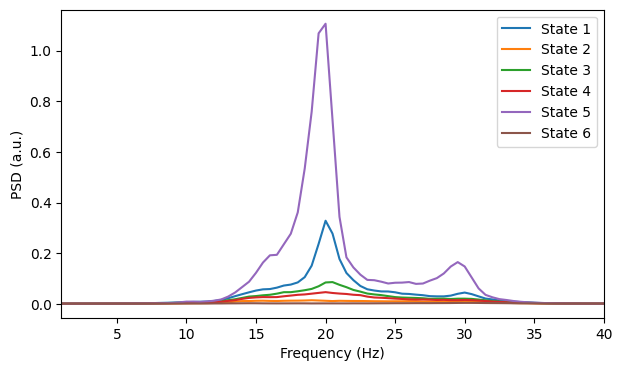

In [157]:
# Plot PSDs 
n_states = psd.shape[0]
fig, ax = plotting.plot_line(
    [f] * n_states,
    psd,
    labels=[f"State {i}" for i in range(1, n_states + 1)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[1, 40]
)

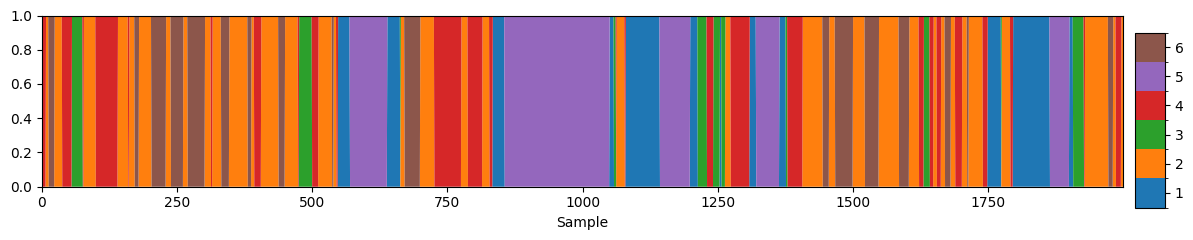

In [158]:
# Hard classify the state probabilities
stc = modes.argmax_time_courses(alpha)

# Plot the state time course for 8 seconds of data 
fig, ax = plotting.plot_alpha(stc[66500:68500, :], cmap='tab10')


In [159]:
print("Total run time: %s seconds" % (time.time() - start_time))

Total run time: 16.32239580154419 seconds
